In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(70736, 14)
(17685, 14)


In [5]:
X_train = train_data.drop(columns=['No-show', 'AppointmentID', 'PatientId'])
y_train = train_data['No-show']

X_test = test_data.drop(columns=['No-show', 'AppointmentID', 'PatientId'])
y_test = test_data['No-show']

# Preprocessing

## Conversione delle colonne datetime

In [6]:
X_train_date = X_train.astype({'ScheduledDay': 'datetime64[D]', 'AppointmentDay': 'datetime64[D]'})
X_test_date = X_test.astype({'ScheduledDay': 'datetime64[D]', 'AppointmentDay': 'datetime64[D]'})

In [7]:
X_train_datediff = X_train_date['AppointmentDay'] - X_train_date['ScheduledDay']
X_test_datediff = X_test_date['AppointmentDay'] - X_test_date['ScheduledDay']

In [8]:
X_train_datediff

0        0 days
1        1 days
2        1 days
3        2 days
4        0 days
          ...  
70731    8 days
70732    0 days
70733   61 days
70734    2 days
70735    0 days
Length: 70736, dtype: timedelta64[ns]

In [9]:
X_train_datediff.astype('timedelta64[D]')

0         0.0
1         1.0
2         1.0
3         2.0
4         0.0
         ... 
70731     8.0
70732     0.0
70733    61.0
70734     2.0
70735     0.0
Length: 70736, dtype: float64

In [10]:
X_train_daydiff = X_train_date.drop(columns=['ScheduledDay', 'AppointmentDay'])
X_train_daydiff['DaysToAppointment'] = X_train_datediff

X_test_daydiff = X_test_date.drop(columns=['ScheduledDay', 'AppointmentDay'])
X_test_daydiff['DaysToAppointment'] = X_test_datediff

In [11]:
X_train_daydiff = X_train_daydiff.drop(columns=['Gender'])
X_test_daydiff = X_test_daydiff.drop(columns=['Gender'])

In [12]:
X_train_daydiff.dtypes

Age                            int64
Neighbourhood                 object
Scholarship                    int64
Hipertension                   int64
Diabetes                       int64
Alcoholism                     int64
Handcap                        int64
SMS_received                   int64
DaysToAppointment    timedelta64[ns]
dtype: object

In [13]:
X_train_daydiff

,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DaysToAppointment
0,21,SÃO CRISTÓVÃO,0,0,0,0,0,0,0 days
1,95,CENTRO,0,1,0,0,0,0,1 days
2,71,CRUZAMENTO,0,0,0,0,0,0,1 days
3,18,CARATOÍRA,0,0,0,0,0,0,2 days
4,45,PRAIA DO SUÁ,1,0,0,0,0,0,0 days
...,...,...,...,...,...,...,...,...,...
70731,30,ITARARÉ,0,1,0,0,0,1,8 days
70732,1,SANTA MARTHA,0,0,0,0,0,0,0 days
70733,43,JARDIM CAMBURI,0,0,0,0,0,1,61 days
70734,17,VILA RUBIM,0,0,0,0,0,0,2 days


## Codifica delle classi di Neighbourhood

In caso di classe poco frequente essa viene codificata con "Other", questo anche per i dati di test, così da evitare possibili errori nel LabelEncoding per nuove classi non viste in precedenza (nel fit).

In [14]:
X_train_temp = X_train_daydiff.drop(columns=['Neighbourhood'])
X_test_temp = X_test_daydiff.drop(columns=['Neighbourhood'])

# LabelEncoding

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [16]:
#X_train_date['Neighbourhood'] = le.fit_transform(X_train_daydiff['Neighbourhood'])
#X_train_date['Neighbourhood'].head(10)

In [17]:
#le.classes_

In [18]:
#X_test_label = le.transform(X_test_date['Neighbourhood'])

# Scelta dei modelli, training e fit

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [20]:
X_train = X_train_temp
X_test = X_test_temp

In [21]:
X_train['DaysToAppointment'] = X_train['DaysToAppointment'].astype('int64')
X_test['DaysToAppointment'] = X_test['DaysToAppointment'].astype('int64')

## DecisionTree

In [22]:
max_loop_depth = 40
max_score = 0
best_depth = 0

for depth in range(1, max_loop_depth):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if(score > max_score):
        max_score = score
        best_depth = depth
    
best_model = DecisionTreeClassifier(max_depth=best_depth, random_state=1)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

Text(0.5, 1.0, 'DecisionTreeClassifier feature importance')

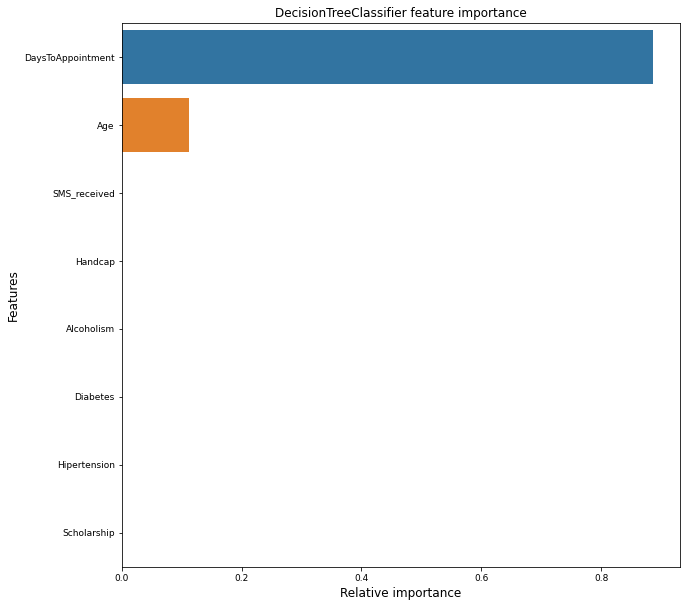

In [23]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(10,10))

indices = np.argsort(best_model.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = best_model.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title('DecisionTreeClassifier' + " feature importance")

In [24]:
print('Training Accuracy: ', best_model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', best_model.score(X_test, y_test) * 100, '%')

Training Accuracy:  79.92676996154717 %
Testing Accuracy:  79.18575063613231 %


## LogisticRegression

In [25]:
model = LogisticRegression(max_iter=1000, random_state=1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1)

In [26]:
print('Training Accuracy: ', model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', model.score(X_test, y_test) * 100, '%')

Training Accuracy:  79.92818366885321 %
Testing Accuracy:  79.18575063613231 %


## RandomForest

In [27]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [28]:
print('Training Accuracy: ', model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', model.score(X_test, y_test) * 100, '%')

Training Accuracy:  85.92937118299028 %
Testing Accuracy:  76.74865705400057 %
